In [1]:
# Gerekli kütüphaneleri yükleyin
!pip install tensorflow requests pandas matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import requests
import datetime


In [37]:
# API'den veri çekme fonksiyonu
def fetch_air_quality_data(lat, lon, start_date, end_date, api_key):
    # API URL'si
    base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history"
    params = {
        "lat": lat,
        "lon": lon,
        "start": int(start_date.timestamp()),
        "end": int(end_date.timestamp()),
        "appid": api_key
    }

    # API isteği
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        records = [
            {
                "date": datetime.datetime.fromtimestamp(item["dt"]),
                "pm2_5": item["components"]["pm2_5"],
                "pm10": item["components"]["pm10"],
            }
            for item in data["list"]
        ]
        return pd.DataFrame(records)
    else:
        print(f"API Hatası: {response.status_code}")
        return None

# API bilgileri
lat = 41.015137  # İstanbul koordinatları
lon = 28.979530
start_date = datetime.datetime(2024, 9, 1)
end_date = datetime.datetime(2024, 12, 31)
api_key = "a7ada9e4cf046c8e0366d43e10d90101"

# Veriyi al
data = fetch_air_quality_data(lat, lon, start_date, end_date, api_key)

if data is not None:
    print(data.head())
else:
    print("Veri alınamadı.")


                 date  pm2_5  pm10
0 2024-09-01 00:00:00   5.92  6.92
1 2024-09-01 01:00:00   6.55  7.68
2 2024-09-01 02:00:00   7.03  8.31
3 2024-09-01 03:00:00   7.25  8.64
4 2024-09-01 04:00:00   7.72  9.24


<ipython-input-38-124002c47236>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = data[target_column].fillna(method="ffill")


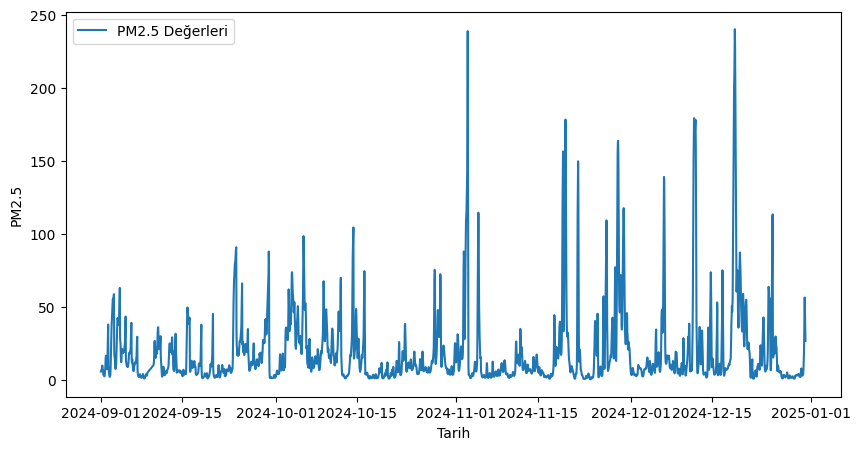

In [38]:
# Tarih sütununu DateTime formatına çevir
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Hedef sütun (PM2.5) seçimi
target_column = 'pm2_5'
time_series = data[target_column].fillna(method="ffill")

# Veriyi görselleştir
plt.figure(figsize=(10, 5))
plt.plot(time_series, label="PM2.5 Değerleri")
plt.xlabel("Tarih")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [39]:
# Zaman serisini kaydırma (örnek: 30 gün geçmiş veri)
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

# Veri kümesi oluşturma
sequence_length = 120  # Geçmiş 30 gün verisi
data_values = time_series.values
sequences, targets = create_sequences(data_values, sequence_length)

# Eğitim ve test verilerini bölme
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 872.3015 - val_loss: 1533.7714
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 448.0308 - val_loss: 1354.6184
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 377.6845 - val_loss: 1235.1691
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 406.6700 - val_loss: 1134.3376
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 366.2870 - val_loss: 1052.0142
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 275.1680 - val_loss: 984.4662
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 367.1498 - val_loss: 924.8799
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 246.5200 - val_loss: 871.8087
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 231.9088 - val_loss: 826.2248
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 201.4681 - val_loss: 782.3769
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 159.5213 - val_loss: 74

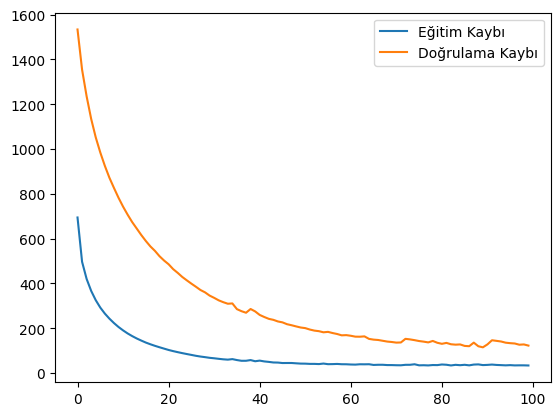

In [40]:
# LSTM modeli oluştur
model = Sequential([
    LSTM(64, input_shape=(sequence_length, 1), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Modeli eğit
history = model.fit(
    X_train.reshape(-1, sequence_length, 1),
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test.reshape(-1, sequence_length, 1), y_test)
)

# Kayıp grafiği
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


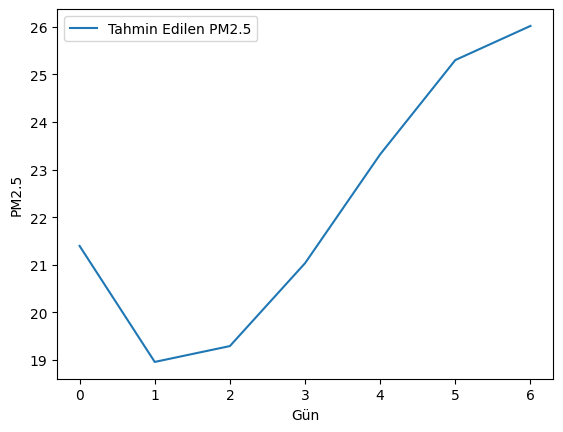

In [41]:
# 1 haftalık tahmin yapma
def predict_future(model, last_sequence, days):
    predictions = []
    current_sequence = last_sequence
    for _ in range(days):
        prediction = model.predict(current_sequence.reshape(1, -1, 1))
        predictions.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[1:], prediction[0, 0])
    return predictions

# Son 30 günü alarak tahmin yap
last_sequence = data_values[-sequence_length:]
future_predictions = predict_future(model, last_sequence, 7)

# Tahmin sonuçlarını görselleştir
plt.plot(range(7), future_predictions, label="Tahmin Edilen PM2.5")
plt.xlabel("Gün")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [ ]:
# Modeli Keras'ın önerilen formatında kaydet
model.save("air_pollution_model.keras")


In [45]:
from google.colab import files

# Kaydedilen modeli bilgisayara indirin
files.download("air_pollution_lstm_model.keras")


FileNotFoundError: Cannot find file: air_pollution_lstm_model.keras